In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier, SGDRegressor
import lightgbm as lgb
from matplotlib import pyplot as plt
import joblib
from pathlib import Path
import sqlite3

In [2]:
pd.options.display.max_rows=100
pd.options.display.max_columns=50

In [3]:
def create_results_df():
    
    path_to_results = Path().home().joinpath('NBA_Model_v1', 'results', 'betting_predictions_2023.csv')
    path_to_db = Path.home().joinpath('NBA_Model_v1', 'data', 'nba.db')
    season = '2023-24'
        
    preds = pd.read_csv(path_to_results)
    preds = preds.drop_duplicates(subset=['home_team', 'away_team', 'game_date'], keep='last')

    connection = sqlite3.connect(path_to_db)
    scores = pd.read_sql(f"""SELECT a.SEASON
                            ,a.GAME_DATE
                            ,a.TEAM_ABBREVIATION AS HOME_TEAM_ABBREVIATION
                            ,b.TEAM_ABBREVIATION AS AWAY_TEAM_ABBREVIATION
                            ,a.PTS AS HOME_TEAM_SCORE
                            ,b.PTS AS AWAY_TEAM_SCORE 
                        FROM team_basic_boxscores a
                        JOIN team_basic_boxscores b
                        ON a.GAME_ID = b.GAME_ID
                        WHERE a.MATCHUP like '%vs%'
                        and a.TEAM_ABBREVIATION != b.TEAM_ABBREVIATION
                        and a.SEASON = '{season}'""", con = connection)

    scores['GAME_DATE'] = pd.to_datetime(scores['GAME_DATE']).astype(str)

    merged = pd.merge(preds, scores, how='left', 
                    left_on = ['home_team', 'game_date'],
                    right_on = ['HOME_TEAM_ABBREVIATION', 'GAME_DATE'])
    
    

    merged['SGD_ATS_DIFF'] = merged['sgd_home_score_pred'] - merged['sgd_away_score_pred'] + merged['home_spread']
    merged['LGB_ATS_DIFF'] = merged['lgb_home_score_pred'] - merged['lgb_away_score_pred'] + merged['home_spread']

    merged['SGD_ATS_BET_HOME'] = (merged['SGD_ATS_DIFF']>0).astype(int)
    merged['LGB_ATS_BET_HOME'] = (merged['LGB_ATS_DIFF']>0).astype(int)

    merged['HOME_SCORE_DIFF'] = merged['HOME_TEAM_SCORE'] - merged['AWAY_TEAM_SCORE']
    merged['HOME_WIN'] = (merged['HOME_SCORE_DIFF']>0).astype(int)

    merged['HOME_COVER'] = ((merged['HOME_SCORE_DIFF'] + merged['home_spread']) > 0).astype(int)
    
    condlist = [merged['home_spread'] < 0
                ,merged['home_spread'] > 0]
    choicelist = [((merged['HOME_SCORE_DIFF'] + merged['home_spread']) > 0).astype(int)
                  ,((-merged['HOME_SCORE_DIFF'] + -merged['home_spread']) > 0).astype(int)]
    
    merged['FAVORITE_COVER'] = np.select(condlist, choicelist, np.nan)
    
    merged.loc[(merged['HOME_SCORE_DIFF'] + merged['home_spread']) == 0, 'HOME_COVER'] = np.nan

    merged['SGD_ATS_BET_RESULT'] = (merged['HOME_COVER'] == merged['SGD_ATS_BET_HOME']).astype(int)
    merged['LGB_ATS_BET_RESULT'] = (merged['HOME_COVER'] == merged['LGB_ATS_BET_HOME']).astype(int)


    merged['SGD_HINGE_ML_BET_RESULT'] = (merged['home_win_prob_sgd_hinge'] == merged['HOME_WIN']).astype(int)
    merged['SGD_LOGLOSS_ML_BET_RESULT'] = (merged['home_win_prob_sgd_logloss'].round() == merged['HOME_WIN']).astype(int)
    merged['LGB_ML_BET_RESULT'] = (merged['home_win_prob_lgbc'].round() == merged['HOME_WIN']).astype(int)


    merged.loc[merged['HOME_SCORE_DIFF'].isnull(), ['HOME_WIN', 'HOME_COVER', 'SGD_ATS_BET_RESULT',
                                                    'LGB_ATS_BET_RESULT', 'SGD_HINGE_ML_BET_RESULT',
                                                    'SGD_LOGLOSS_ML_BET_RESULT', 'LGB_ML_BET_RESULT']] = np.nan


    merged = merged.drop(columns = ['GAME_DATE', 'SEASON', 'HOME_TEAM_ABBREVIATION'])
    
    return merged

In [4]:
results = create_results_df()

results

,home_team,away_team,game_date,home_spread,home_moneylines,away_moneylines,OU,sgd_home_score_pred,sgd_away_score_pred,lgb_home_score_pred,lgb_away_score_pred,home_win_prob_sgd_hinge,home_win_prob_sgd_logloss,away_win_prob_sgd_logloss,home_win_prob_lgbc,away_win_prob_lgbc,AWAY_TEAM_ABBREVIATION,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,SGD_ATS_DIFF,LGB_ATS_DIFF,SGD_ATS_BET_HOME,LGB_ATS_BET_HOME,HOME_SCORE_DIFF,HOME_WIN,HOME_COVER,FAVORITE_COVER,SGD_ATS_BET_RESULT,LGB_ATS_BET_RESULT,SGD_HINGE_ML_BET_RESULT,SGD_LOGLOSS_ML_BET_RESULT,LGB_ML_BET_RESULT
0,DEN,LAL,2023-10-24,-5.0,1.505051,2.640000,229.0,109.638723,106.726624,112.143990,108.647572,1,0.653387,0.346613,0.585974,0.414026,LAL,119.0,107.0,-2.087901,-1.503582,0,0,12.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
1,GSW,PHX,2023-10-24,-2.5,1.704225,2.200000,235.0,115.391802,111.710191,113.905116,109.661801,1,0.640132,0.359868,0.675796,0.324204,PHX,104.0,108.0,1.181611,1.743315,1,1,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NYK,BOS,2023-10-25,3.5,2.400000,1.602410,223.0,101.368858,107.863198,101.048626,102.693297,0,0.349277,0.650723,0.407684,0.592316,BOS,104.0,108.0,-2.994340,1.855330,0,1,-4.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,IND,WAS,2023-10-25,-5.0,1.487805,2.700000,235.5,118.099739,116.671203,116.403545,117.595559,1,0.496361,0.503639,0.571341,0.428659,WAS,143.0,120.0,-3.571464,-6.192014,0,0,23.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
4,CHA,ATL,2023-10-25,3.5,2.420000,1.588235,236.0,108.068218,112.622785,111.334242,117.942329,0,0.278167,0.721833,0.396972,0.603028,ATL,116.0,110.0,-1.054567,-3.108087,0,0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,WAS,TOR,2023-12-27,7.0,3.200000,1.370370,240.5,115.063539,125.572652,118.227036,121.583883,0,0.166967,0.833033,0.371666,0.628334,NaN,NaN,NaN,-3.509113,3.643153,0,1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
423,BKN,MIL,2023-12-27,4.5,2.600000,1.526316,240.5,117.364624,123.258109,121.625716,122.097668,0,0.262625,0.737375,0.474192,0.525808,NaN,NaN,NaN,-1.393485,4.028048,0,1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
424,HOU,PHX,2023-12-27,3.0,2.200000,1.704225,225.5,114.884181,114.535177,115.872120,113.364290,1,0.472812,0.527188,0.543174,0.456826,NaN,NaN,NaN,3.349004,5.507830,1,1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
425,OKC,NYK,2023-12-27,-3.0,1.657895,2.280000,240.0,120.789305,119.025850,123.142959,119.205225,1,0.551682,0.448318,0.561172,0.438828,NaN,NaN,NaN,-1.236545,0.937734,0,1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [5]:
results[['home_team', 'away_team', 'game_date', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'home_spread', 'FAVORITE_COVER']]

,home_team,away_team,game_date,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,home_spread,FAVORITE_COVER
0,DEN,LAL,2023-10-24,119.0,107.0,-5.0,1.0
1,GSW,PHX,2023-10-24,104.0,108.0,-2.5,0.0
2,NYK,BOS,2023-10-25,104.0,108.0,3.5,1.0
3,IND,WAS,2023-10-25,143.0,120.0,-5.0,1.0
4,CHA,ATL,2023-10-25,116.0,110.0,3.5,0.0
...,...,...,...,...,...,...,...
422,WAS,TOR,2023-12-27,NaN,NaN,7.0,0.0
423,BKN,MIL,2023-12-27,NaN,NaN,4.5,0.0
424,HOU,PHX,2023-12-27,NaN,NaN,3.0,0.0
425,OKC,NYK,2023-12-27,NaN,NaN,-3.0,0.0


In [6]:
results['home_score_err'] = results['sgd_home_score_pred'] - results['HOME_TEAM_SCORE']
results['away_score_err'] = results['sgd_away_score_pred'] - results['AWAY_TEAM_SCORE']

results['implied_home_win_prob'] = 1/results['home_moneylines']


<AxesSubplot: >

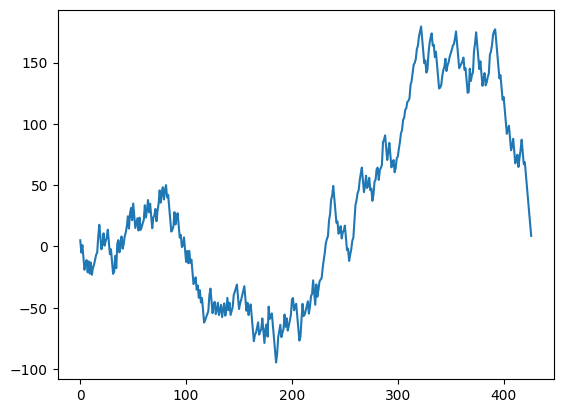

In [7]:
def simulate_ml_bets_all(results, bet_amt):
    results = results.copy(deep=True)
    results['bankroll_n'] = np.nan
    results['bankroll_i'] = np.nan
    results['bet_size'] = 10

    results.loc[0, 'bankroll_i'] = 0
    for i, row in results.iterrows():
        if row['home_win_prob_sgd_logloss'] > 0.5: 
            # results.at[i, 'bet_size'] = bet_amt / (row['home_moneylines'] - 1)
            if row['SGD_LOGLOSS_ML_BET_RESULT'] == 1:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] +  (results.at[i, 'bet_size'] * (results.at[i, 'home_moneylines']-1))
            else:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] - results.at[i, 'bet_size']
            results.at[i+1, 'bankroll_i'] = results.at[i, 'bankroll_n'] 
        elif row['home_win_prob_sgd_logloss'] < 0.5: 
            # results.at[i, 'bet_size'] = bet_amt / (row['away_moneylines'] - 1)
            if row['SGD_LOGLOSS_ML_BET_RESULT'] == 1:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] + (results.at[i, 'bet_size'] * (results.at[i, 'away_moneylines']-1))
            else:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] - results.at[i, 'bet_size']
            results.at[i+1, 'bankroll_i'] = results.at[i, 'bankroll_n'] 
 
    return results            

bet_results = simulate_ml_bets_all(results, bet_amt=10)
bet_results['bankroll_n'].plot()

In [8]:
bet_results[['home_team', 'away_team', 'game_date', 'home_moneylines', 
            'away_moneylines', 'HOME_WIN', 'HOME_COVER', 'implied_home_win_prob',
            'home_win_prob_sgd_logloss', 'SGD_LOGLOSS_ML_BET_RESULT', 'bankroll_i', 'bet_size', 'bankroll_n',
            ]]

,home_team,away_team,game_date,home_moneylines,away_moneylines,HOME_WIN,HOME_COVER,implied_home_win_prob,home_win_prob_sgd_logloss,SGD_LOGLOSS_ML_BET_RESULT,bankroll_i,bet_size,bankroll_n
0,DEN,LAL,2023-10-24,1.505051,2.640000,1.0,1.0,0.664430,0.653387,1.0,0.000000,10.0,5.050505
1,GSW,PHX,2023-10-24,1.704225,2.200000,0.0,0.0,0.586777,0.640132,0.0,5.050505,10.0,-4.949495
2,NYK,BOS,2023-10-25,2.400000,1.602410,0.0,0.0,0.416667,0.349277,1.0,-4.949495,10.0,1.074601
3,IND,WAS,2023-10-25,1.487805,2.700000,1.0,1.0,0.672131,0.496361,0.0,1.074601,10.0,-8.925399
4,CHA,ATL,2023-10-25,2.420000,1.588235,1.0,1.0,0.413223,0.278167,0.0,-8.925399,10.0,-18.925399
...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,BKN,MIL,2023-12-27,2.600000,1.526316,NaN,NaN,0.384615,0.262625,NaN,48.645808,10.0,38.645808
424,HOU,PHX,2023-12-27,2.200000,1.704225,NaN,NaN,0.454545,0.472812,NaN,38.645808,10.0,28.645808
425,OKC,NYK,2023-12-27,1.657895,2.280000,NaN,NaN,0.603175,0.551682,NaN,28.645808,10.0,18.645808
426,DAL,CLE,2023-12-27,1.581395,2.440000,NaN,NaN,0.632353,0.413986,NaN,18.645808,10.0,8.645808


In [9]:
def simulate_ml_bets(results, bet_amt):
    results = results.copy(deep=True)
    results['bankroll_n'] = np.nan
    results['bankroll_i'] = np.nan
    results = results.dropna(subset=['HOME_WIN'])
    results.loc[0, 'bankroll_i'] = 0
    for i, row in results.iterrows():
        if (row['home_win_prob_sgd_logloss'] > row['implied_home_win_prob']) and row['home_win_prob_sgd_logloss'] > 0.5:
            if row['HOME_WIN'] == 1:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] + (bet_amt) * (results.at[i, 'home_moneylines']-1)
            else:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] - bet_amt
            results.at[i+1, 'bankroll_i'] = results.at[i, 'bankroll_n']

        elif (row['home_win_prob_sgd_logloss'] < row['implied_home_win_prob']) and row['home_win_prob_sgd_logloss'] < 0.5:
            if row['HOME_WIN'] == 0:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] + (bet_amt) * (results.at[i, 'away_moneylines']-1)
            else:
                results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i'] - bet_amt
            results.at[i+1, 'bankroll_i'] = results.at[i, 'bankroll_n']
        else:
            results.at[i, 'bankroll_n'] = results.at[i, 'bankroll_i']
            results.at[i+1, 'bankroll_i'] = results.at[i, 'bankroll_n']
        
    return results            

bet_results = simulate_ml_bets(results, bet_amt=10)

In [10]:
bet_results[['home_team', 'away_team', 'game_date', 'home_moneylines', 
            'away_moneylines', 'HOME_WIN', 'HOME_COVER', 'implied_home_win_prob',
            'home_win_prob_sgd_logloss', 'SGD_LOGLOSS_ML_BET_RESULT', 'bankroll_i', 'bankroll_n',
            ]]

,home_team,away_team,game_date,home_moneylines,away_moneylines,HOME_WIN,HOME_COVER,implied_home_win_prob,home_win_prob_sgd_logloss,SGD_LOGLOSS_ML_BET_RESULT,bankroll_i,bankroll_n
0,DEN,LAL,2023-10-24,1.505051,2.640000,1.0,1.0,0.664430,0.653387,1.0,0.000000,0.000000
1,GSW,PHX,2023-10-24,1.704225,2.200000,0.0,0.0,0.586777,0.640132,0.0,0.000000,-10.000000
2,NYK,BOS,2023-10-25,2.400000,1.602410,0.0,0.0,0.416667,0.349277,1.0,-10.000000,-3.975904
3,IND,WAS,2023-10-25,1.487805,2.700000,1.0,1.0,0.672131,0.496361,0.0,-3.975904,-13.975904
4,CHA,ATL,2023-10-25,2.420000,1.588235,1.0,1.0,0.413223,0.278167,0.0,-13.975904,-23.975904
...,...,...,...,...,...,...,...,...,...,...,...,...
418,HOU,IND,2023-12-26,1.649351,2.300000,0.0,0.0,0.606299,0.507066,0.0,NaN,NaN
419,POR,SAC,2023-12-26,3.600000,1.312500,1.0,1.0,0.277778,0.102926,0.0,NaN,NaN
420,LAC,CHA,2023-12-26,1.153846,5.800000,1.0,0.0,0.866667,0.755636,1.0,NaN,NaN
297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.285504,NaN


<AxesSubplot: >

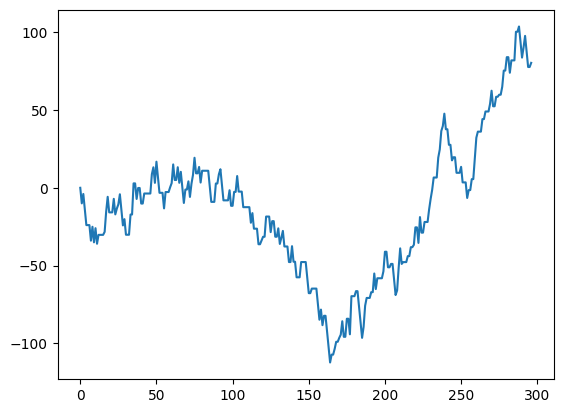

In [11]:
bet_results['bankroll_n'].plot()

In [12]:
bet_results.loc[((bet_results['home_win_prob_sgd_logloss'] > bet_results['implied_home_win_prob']) & (bet_results['home_win_prob_sgd_logloss'] > 0.5))
                | ((bet_results['home_win_prob_sgd_logloss'] < bet_results['implied_home_win_prob']) & (bet_results['home_win_prob_sgd_logloss'] < 0.5)), 'SGD_LOGLOSS_ML_BET_RESULT'].mean()



0.5931558935361216

In [13]:
bet_results.loc[((bet_results['home_win_prob_sgd_logloss'] < bet_results['implied_home_win_prob']) & bet_results['home_win_prob_sgd_logloss'] < 0.5)]

,home_team,away_team,game_date,home_spread,home_moneylines,away_moneylines,OU,sgd_home_score_pred,sgd_away_score_pred,lgb_home_score_pred,lgb_away_score_pred,home_win_prob_sgd_hinge,home_win_prob_sgd_logloss,away_win_prob_sgd_logloss,home_win_prob_lgbc,away_win_prob_lgbc,AWAY_TEAM_ABBREVIATION,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,SGD_ATS_DIFF,LGB_ATS_DIFF,SGD_ATS_BET_HOME,LGB_ATS_BET_HOME,HOME_SCORE_DIFF,HOME_WIN,HOME_COVER,FAVORITE_COVER,SGD_ATS_BET_RESULT,LGB_ATS_BET_RESULT,SGD_HINGE_ML_BET_RESULT,SGD_LOGLOSS_ML_BET_RESULT,LGB_ML_BET_RESULT,home_score_err,away_score_err,implied_home_win_prob,bankroll_n,bankroll_i
1,GSW,PHX,2023-10-24,-2.5,1.704225,2.200000,235.0,115.391802,111.710191,113.905116,109.661801,1.0,0.640132,0.359868,0.675796,0.324204,PHX,104.0,108.0,1.181611,1.743315,1.0,1.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.391802,3.710191,0.586777,-10.000000,0.000000
7,BKN,CLE,2023-10-25,2.0,2.100000,1.769231,218.5,103.460638,101.486390,101.943011,101.825335,1.0,0.603582,0.396418,0.452092,0.547908,CLE,113.0,114.0,3.974248,2.117676,1.0,1.0,-1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,-9.539362,-12.513610,0.476190,-33.975904,-23.975904
8,TOR,MIN,2023-10-25,1.0,1.892857,1.925926,220.5,114.195984,104.971355,115.851544,106.633950,1.0,0.836563,0.163437,0.777223,0.222777,MIN,97.0,94.0,10.224628,10.217594,1.0,1.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,17.195984,10.971355,0.528302,-25.047332,-33.975904
9,CHI,OKC,2023-10-25,-2.5,1.740741,2.140000,224.5,114.750018,110.244359,118.489391,110.239484,1.0,0.698073,0.301927,0.765337,0.234663,OKC,104.0,124.0,2.005659,5.749908,1.0,1.0,-20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.750018,-13.755641,0.574468,-35.047332,-25.047332
11,UTA,SAC,2023-10-25,1.5,2.050000,1.800000,234.0,121.862052,120.018573,120.689142,115.570417,1.0,0.583753,0.416247,0.588463,0.411537,SAC,114.0,130.0,3.343479,6.618725,1.0,1.0,-16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.862052,-9.981427,0.487805,-35.956423,-25.956423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,OKC,MIN,2023-12-26,-2.5,1.757576,2.120000,228.0,119.180312,115.519514,117.330751,114.851248,1.0,0.594504,0.405496,0.552463,0.447537,MIN,129.0,106.0,1.160798,-0.020496,1.0,0.0,23.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,-9.819688,9.519514,0.568966,NaN,NaN
416,SAS,UTA,2023-12-26,3.5,2.340000,1.632911,242.0,118.048111,120.109931,115.777537,118.896303,1.0,0.467056,0.532944,0.364196,0.635804,UTA,118.0,130.0,1.438180,0.381234,1.0,1.0,-12.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.048111,-9.890069,0.427350,NaN,NaN
417,CHI,ATL,2023-12-26,-1.5,1.833333,2.020000,233.5,117.180702,115.935257,119.767908,115.618118,1.0,0.554503,0.445497,0.635796,0.364204,ATL,118.0,113.0,-0.254555,2.649790,0.0,1.0,5.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,-0.819298,2.935257,0.545455,NaN,NaN
297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.285504


In [14]:
home_betting_results = results.groupby(['home_team'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count')).reset_index().rename(columns={
                                                                                                                 'sum':'home_ats_wins',
                                                                                                                 'count':'home_num_games'})


away_betting_results = results.groupby(['away_team'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count')).reset_index().rename(columns={
                                                                                                                 'sum':'away_ats_wins',
                                                                                                                 'count':'away_num_games'})


betting_stats_by_team = pd.merge(home_betting_results, away_betting_results, how='inner', left_on = 'home_team', right_on='away_team')
betting_stats_by_team['ats_wins'] = betting_stats_by_team['home_ats_wins'] + betting_stats_by_team['away_ats_wins']
betting_stats_by_team['num_games'] = betting_stats_by_team['home_num_games'] + betting_stats_by_team['away_num_games']
betting_stats_by_team['ats_pct'] = betting_stats_by_team['ats_wins'] / betting_stats_by_team['num_games']

betting_stats_by_team = betting_stats_by_team.drop(columns=['away_team'])

betting_stats_by_team.sort_values('ats_pct', ascending=False)

,home_team,home_ats_wins,home_num_games,away_ats_wins,away_num_games,ats_wins,num_games,ats_pct
9,GSW,9.0,15,8.0,13,17.0,28,0.607143
18,NOP,8.0,15,10.0,15,18.0,30,0.600000
2,BOS,5.0,13,11.0,15,16.0,28,0.571429
5,CLE,9.0,14,7.0,14,16.0,28,0.571429
11,IND,9.0,15,7.0,13,16.0,28,0.571429
3,CHA,8.0,14,7.0,13,15.0,27,0.555556
16,MIL,8.0,17,8.0,12,16.0,29,0.551724
15,MIA,8.0,15,7.0,13,15.0,28,0.535714
13,LAL,7.0,14,9.0,16,16.0,30,0.533333
1,BKN,7.0,16,8.0,13,15.0,29,0.517241


In [15]:
results['bet_favorite'] = (((results['home_spread'] < 0) & (results['SGD_ATS_BET_HOME'] == 1)) 
                           |((results['home_spread'] > 0) & (results['SGD_ATS_BET_HOME'] == 0))).astype(int)


results['home_favored'] = (results['home_spread'] < 0).astype(int)

results['sgd_home_point_pred_winner'] = (results['sgd_home_score_pred'] - results['sgd_away_score_pred'] > 0).astype(int)
results['lgb_home_point_pred_winner'] = (results['lgb_home_score_pred'] - results['lgb_away_score_pred'] > 0).astype(int)

results['sgd_point_pred_correct'] = (results['sgd_home_point_pred_winner'] == results['HOME_WIN']).astype(int)
results['lgb_point_pred_correct'] = (results['lgb_home_point_pred_winner'] == results['HOME_WIN']).astype(int)

results['sgd_home_point_diff_pred'] = results['sgd_home_score_pred'] - results['sgd_away_score_pred']
results['lgb_home_point_diff_pred'] = results['lgb_home_score_pred'] - results['lgb_away_score_pred']


results['sgd_fav_eq_vegas_fav'] = (np.sign(results['home_spread']) != np.sign(results['sgd_home_point_diff_pred'])).astype(int)
results['lgb_fav_eq_vegas_fav'] = (np.sign(results['home_spread']) != np.sign(results['lgb_home_point_diff_pred'])).astype(int)

results['SGD_spread_diff<1'] = (results['SGD_ATS_DIFF'].abs() < 1).astype(int)
results['SGD_spread_diff>1'] = (results['SGD_ATS_DIFF'].abs() >= 1).astype(int)
results['SGD_spread_diff>2'] = (results['SGD_ATS_DIFF'].abs() >= 2).astype(int)
results['SGD_spread_diff>3'] = (results['SGD_ATS_DIFF'].abs() >= 3).astype(int)
results['SGD_spread_diff>4'] = (results['SGD_ATS_DIFF'].abs() >= 4).astype(int)

results['LGB_spread_diff<1'] = (results['LGB_ATS_DIFF'].abs() < 1).astype(int)
results['LGB_spread_diff>1'] = (results['LGB_ATS_DIFF'].abs() >= 1).astype(int)
results['LGB_spread_diff>2'] = (results['LGB_ATS_DIFF'].abs() >= 2).astype(int)
results['LGB_spread_diff>3'] = (results['LGB_ATS_DIFF'].abs() >= 3).astype(int)
results['LGB_spread_diff>4'] = (results['LGB_ATS_DIFF'].abs() >= 4).astype(int)


results['spread_under3'] = results['home_spread'].between(-2.5,2.5).astype(int)
results['spread_3to6'] = (results['home_spread'].between(-5.5, 3) | results['home_spread'].between(3, 5.5)).astype(int)
results['spread_6to9'] = (results['home_spread'].between(-8.5,-6) | results['home_spread'].between(3, 8.6)).astype(int)
results['spread_over9'] = (results['home_spread'].abs()>=9).astype(int)

condlist = [results['home_spread'].between(-2.5,2.5), 
            (results['home_spread'].between(-5.5, 3) | results['home_spread'].between(3, 5.5)),
            (results['home_spread'].between(-8.5,-6) | results['home_spread'].between(3, 8.6)),
            results['home_spread'].abs()>=9]

choicelist = ['0to3', '3to5.5', '6to8.5', '9+']

results['spread_type'] = np.select(condlist, choicelist)


# results['spread_bin1'] = pd.cut(results['home_spread'], bins= np.arange(-14, 15, 1))
# results['spread_bin2'] = pd.cut(results['home_spread'], bins= np.arange(-14, 15, 2))
# results['spread_bin4'] = pd.cut(results['home_spread'], bins= np.arange(-14, 15, 4))


In [16]:
results

,home_team,away_team,game_date,home_spread,home_moneylines,away_moneylines,OU,sgd_home_score_pred,sgd_away_score_pred,lgb_home_score_pred,lgb_away_score_pred,home_win_prob_sgd_hinge,home_win_prob_sgd_logloss,away_win_prob_sgd_logloss,home_win_prob_lgbc,away_win_prob_lgbc,AWAY_TEAM_ABBREVIATION,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,SGD_ATS_DIFF,LGB_ATS_DIFF,SGD_ATS_BET_HOME,LGB_ATS_BET_HOME,HOME_SCORE_DIFF,HOME_WIN,...,bet_favorite,home_favored,sgd_home_point_pred_winner,lgb_home_point_pred_winner,sgd_point_pred_correct,lgb_point_pred_correct,sgd_home_point_diff_pred,lgb_home_point_diff_pred,sgd_fav_eq_vegas_fav,lgb_fav_eq_vegas_fav,SGD_spread_diff<1,SGD_spread_diff>1,SGD_spread_diff>2,SGD_spread_diff>3,SGD_spread_diff>4,LGB_spread_diff<1,LGB_spread_diff>1,LGB_spread_diff>2,LGB_spread_diff>3,LGB_spread_diff>4,spread_under3,spread_3to6,spread_6to9,spread_over9,spread_type
0,DEN,LAL,2023-10-24,-5.0,1.505051,2.640000,229.0,109.638723,106.726624,112.143990,108.647572,1,0.653387,0.346613,0.585974,0.414026,LAL,119.0,107.0,-2.087901,-1.503582,0,0,12.0,1.0,...,0,1,1,1,1,1,2.912099,3.496418,1,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,3to5.5
1,GSW,PHX,2023-10-24,-2.5,1.704225,2.200000,235.0,115.391802,111.710191,113.905116,109.661801,1,0.640132,0.359868,0.675796,0.324204,PHX,104.0,108.0,1.181611,1.743315,1,1,-4.0,0.0,...,1,1,1,1,0,0,3.681611,4.243315,1,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0to3
2,NYK,BOS,2023-10-25,3.5,2.400000,1.602410,223.0,101.368858,107.863198,101.048626,102.693297,0,0.349277,0.650723,0.407684,0.592316,BOS,104.0,108.0,-2.994340,1.855330,0,1,-4.0,0.0,...,1,0,0,0,1,1,-6.494340,-1.644670,1,1,0,1,1,0,0,0,1,0,0,0,0,1,1,0,3to5.5
3,IND,WAS,2023-10-25,-5.0,1.487805,2.700000,235.5,118.099739,116.671203,116.403545,117.595559,1,0.496361,0.503639,0.571341,0.428659,WAS,143.0,120.0,-3.571464,-6.192014,0,0,23.0,1.0,...,0,1,1,0,1,0,1.428536,-1.192014,1,0,0,1,1,1,0,0,1,1,1,1,0,1,0,0,3to5.5
4,CHA,ATL,2023-10-25,3.5,2.420000,1.588235,236.0,108.068218,112.622785,111.334242,117.942329,0,0.278167,0.721833,0.396972,0.603028,ATL,116.0,110.0,-1.054567,-3.108087,0,0,6.0,1.0,...,1,0,0,0,0,0,-4.554567,-6.608087,1,1,0,1,0,0,0,0,1,1,1,0,0,1,1,0,3to5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,WAS,TOR,2023-12-27,7.0,3.200000,1.370370,240.5,115.063539,125.572652,118.227036,121.583883,0,0.166967,0.833033,0.371666,0.628334,NaN,NaN,NaN,-3.509113,3.643153,0,1,NaN,NaN,...,1,0,0,0,0,0,-10.509113,-3.356847,1,1,0,1,1,1,0,0,1,1,1,0,0,0,1,0,6to8.5
423,BKN,MIL,2023-12-27,4.5,2.600000,1.526316,240.5,117.364624,123.258109,121.625716,122.097668,0,0.262625,0.737375,0.474192,0.525808,NaN,NaN,NaN,-1.393485,4.028048,0,1,NaN,NaN,...,1,0,0,0,0,0,-5.893485,-0.471952,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,0,3to5.5
424,HOU,PHX,2023-12-27,3.0,2.200000,1.704225,225.5,114.884181,114.535177,115.872120,113.364290,1,0.472812,0.527188,0.543174,0.456826,NaN,NaN,NaN,3.349004,5.507830,1,1,NaN,NaN,...,0,0,1,1,0,0,0.349004,2.507830,0,0,0,1,1,1,0,0,1,1,1,1,0,1,1,0,3to5.5
425,OKC,NYK,2023-12-27,-3.0,1.657895,2.280000,240.0,120.789305,119.025850,123.142959,119.205225,1,0.551682,0.448318,0.561172,0.438828,NaN,NaN,NaN,-1.236545,0.937734,0,1,NaN,NaN,...,0,1,1,1,0,0,1.763455,3.937734,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,3to5.5


In [18]:
# results[['home_team', 'away_team', 'game_date', 'home_spread', 'home_favored',
#          'spread_under3', 'spread_3to6', 'spread_6to9', 'spread_over9', 'spread_type',
#          'SGD_ATS_BET_HOME', 'bet_favorite', 'SGD_ATS_DIFF', 'SGD_ATS_BET_RESULT', 
#          'FAVORITE_COVER', 'HOME_COVER', 'sgd_home_point_diff_pred', 'lgb_home_point_diff_pred', 
#          'sgd_home_point_pred_winner', 'lgb_home_point_pred_winner', 
#          'model_fav_eq_vegas_fav', 'SGD_spread_diff<1', 'SGD_spread_diff>1','SGD_spread_diff>2',
#          'SGD_spread_diff>3','SGD_spread_diff>4', 'LGB_spread_diff<1', 'LGB_spread_diff>1',
#          'LGB_spread_diff>2', 'LGB_spread_diff>3', 'LGB_spread_diff>4'
         
#          ]]

In [19]:
results.groupby(['home_favored'])[['SGD_ATS_BET_RESULT', 'LGB_ATS_BET_RESULT', 'HOME_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                 LGB_ATS_BET_RESULT        \
                            sum count      mean                sum count   
home_favored                                                               
0                          72.0   153  0.470588               88.0   153   
1                         121.0   267  0.453184              127.0   267   

                       HOME_COVER                  
                  mean        sum count      mean  
home_favored                                       
0             0.575163       72.0   149  0.483221  
1             0.475655      134.0   261  0.513410

In [20]:
results.groupby(['sgd_fav_eq_vegas_fav'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                
                                    sum count      mean
sgd_fav_eq_vegas_fav                                   
0                                  41.0    82  0.500000
1                                 152.0   338  0.449704

In [21]:
results.groupby(['lgb_fav_eq_vegas_fav'])[['LGB_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

LGB_ATS_BET_RESULT                
                                    sum count      mean
lgb_fav_eq_vegas_fav                                   
0                                  50.0    94  0.531915
1                                 165.0   326  0.506135

In [22]:
results.groupby(['SGD_ATS_BET_HOME', 'home_favored', 'sgd_home_point_pred_winner'])[['SGD_ATS_BET_RESULT', 'HOME_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                        sum   
SGD_ATS_BET_HOME home_favored sgd_home_point_pred_winner                      
0                0            0                                        20.0   
                 1            0                                        14.0   
                              1                                        45.0   
1                0            0                                        25.0   
                              1                                        27.0   
                 1            1                                        62.0   

                                                                          \
                                                         count      mean   
SGD_ATS_BET_HOME home_favored sgd_home_point_pred_winner                   
0                0            0                             40  0.500000   
                 1            0                             25  0.560000   
                              1                            109  0.412844   
1                0            0                             56  0.446429   
                              1                             57  0.473684   
                 1            1                            133  0.466165   

                                                         HOME_COVER        \
                                                                sum count   
SGD_ATS_BET_HOME home_favored sgd_home_point_pred_winner                    
0                0            0                                20.0    40   
                 1            0                                10.0    24   
                              1                                62.0   107   
1                0            0                                25.0    54   
                              1                                27.0    55   
                 1            1                                62.0   130   

                                                                    
                                                              mean  
SGD_ATS_BET_HOME home_favored sgd_home_point_pred_winner            
0                0            0                           0.500000  
                 1            0                           0.416667  
                              1                           0.579439  
1                0            0                           0.462963  
                              1                           0.490909  
                 1            1                           0.476923

In [23]:
results.groupby(['LGB_ATS_BET_HOME', 'home_favored', 'lgb_home_point_pred_winner'])[['LGB_ATS_BET_RESULT', 'HOME_COVER']].agg(('sum', 'count', 'mean'))

LGB_ATS_BET_RESULT  \
                                                                        sum   
LGB_ATS_BET_HOME home_favored lgb_home_point_pred_winner                      
0                0            0                                        28.0   
                 1            0                                        25.0   
                              1                                        54.0   
1                0            0                                        35.0   
                              1                                        25.0   
                 1            1                                        48.0   

                                                                          \
                                                         count      mean   
LGB_ATS_BET_HOME home_favored lgb_home_point_pred_winner                   
0                0            0                             40  0.700000   
                 1            0                             48  0.520833   
                              1                            119  0.453782   
1                0            0                             67  0.522388   
                              1                             46  0.543478   
                 1            1                            100  0.480000   

                                                         HOME_COVER        \
                                                                sum count   
LGB_ATS_BET_HOME home_favored lgb_home_point_pred_winner                    
0                0            0                                12.0    40   
                 1            0                                22.0    47   
                              1                                64.0   118   
1                0            0                                35.0    65   
                              1                                25.0    44   
                 1            1                                48.0    96   

                                                                    
                                                              mean  
LGB_ATS_BET_HOME home_favored lgb_home_point_pred_winner            
0                0            0                           0.300000  
                 1            0                           0.468085  
                              1                           0.542373  
1                0            0                           0.538462  
                              1                           0.568182  
                 1            1                           0.500000

In [24]:
results.groupby(['spread_type', 'bet_favorite'])[['SGD_ATS_BET_RESULT', 'LGB_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                  \
                                        sum count      mean   
spread_type bet_favorite                                      
0to3        0                          20.0    53  0.377358   
            1                          22.0    42  0.523810   
3to5.5      0                          49.0    87  0.563218   
            1                          21.0    59  0.355932   
6to8.5      0                          23.0    61  0.377049   
            1                          26.0    40  0.650000   
9+          0                          19.0    46  0.413043   
            1                          13.0    32  0.406250   

                         LGB_ATS_BET_RESULT                  
                                        sum count      mean  
spread_type bet_favorite                                     
0to3        0                          27.0    53  0.509434  
            1                          18.0    42  0.428571  
3to5.5      0                          50.0    87  0.574713  
            1                          36.0    59  0.610169  
6to8.5      0                          26.0    61  0.426230  
            1                          24.0    40  0.600000  
9+          0                          19.0    46  0.413043  
            1                          15.0    32  0.468750

In [25]:
results.groupby(['spread_type', 'SGD_ATS_BET_HOME', 'home_favored'])[['SGD_ATS_BET_RESULT', 'HOME_COVER', 'FAVORITE_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                  \
                                                         sum count      mean   
spread_type SGD_ATS_BET_HOME home_favored                                      
0to3        0                0                           6.0    11  0.545455   
                             1                           7.0    18  0.388889   
            1                0                          13.0    35  0.371429   
                             1                          16.0    31  0.516129   
3to5.5      0                0                           6.0    15  0.400000   
                             1                          25.0    45  0.555556   
            1                0                          24.0    42  0.571429   
                             1                          15.0    44  0.340909   
6to8.5      0                0                           6.0    12  0.500000   
                             1                          13.0    35  0.371429   
            1                0                          10.0    26  0.384615   
                             1                          20.0    28  0.714286   
9+          0                0                           2.0     2  1.000000   
                             1                          14.0    36  0.388889   
            1                0                           5.0    10  0.500000   
                             1                          11.0    30  0.366667   

                                          HOME_COVER                  \
                                                 sum count      mean   
spread_type SGD_ATS_BET_HOME home_favored                              
0to3        0                0                   5.0    11  0.454545   
                             1                  11.0    18  0.611111   
            1                0                  13.0    34  0.382353   
                             1                  16.0    31  0.516129   
3to5.5      0                0                   9.0    15  0.600000   
                             1                  18.0    43  0.418605   
            1                0                  24.0    41  0.585366   
                             1                  15.0    43  0.348837   
6to8.5      0                0                   6.0    12  0.500000   
                             1                  22.0    35  0.628571   
            1                0                  10.0    25  0.400000   
                             1                  20.0    28  0.714286   
9+          0                0                   0.0     2  0.000000   
                             1                  21.0    35  0.600000   
            1                0                   5.0     9  0.555556   
                             1                  11.0    28  0.392857   

                                          FAVORITE_COVER                  
                                                     sum count      mean  
spread_type SGD_ATS_BET_HOME home_favored                                 
0to3        0                0                       6.0    11  0.545455  
                             1                      11.0    19  0.578947  
            1                0                      21.0    35  0.600000  
                             1                      16.0    31  0.516129  
3to5.5      0                0                       6.0    16  0.375000  
                             1                      18.0    48  0.375000  
            1                0                      17.0    43  0.395349  
                             1                      15.0    44  0.340909  
6to8.5      0                0                       6.0    13  0.461538  
                             1                      22.0    35  0.628571  
            1                0                      15.0    26  0.576923  
                             1                      20.0    28  0.714286  
9+          0              

In [26]:
results.groupby(['spread_type', 'LGB_ATS_BET_HOME', 'home_favored'])[['LGB_ATS_BET_RESULT', 'HOME_COVER', 'FAVORITE_COVER']].agg(('sum', 'count', 'mean'))

LGB_ATS_BET_RESULT                  \
                                                         sum count      mean   
spread_type LGB_ATS_BET_HOME home_favored                                      
0to3        0                0                          10.0    14  0.714286   
                             1                          11.0    28  0.392857   
            1                0                          14.0    32  0.437500   
                             1                          10.0    21  0.476190   
3to5.5      0                0                           7.0    10  0.700000   
                             1                          32.0    49  0.653061   
            1                0                          30.0    47  0.638298   
                             1                          17.0    40  0.425000   
6to8.5      0                0                           9.0    14  0.642857   
                             1                          13.0    38  0.342105   
            1                0                          11.0    24  0.458333   
                             1                          17.0    25  0.680000   
9+          0                0                           2.0     2  1.000000   
                             1                          23.0    52  0.442308   
            1                0                           5.0    10  0.500000   
                             1                           4.0    14  0.285714   

                                          HOME_COVER                  \
                                                 sum count      mean   
spread_type LGB_ATS_BET_HOME home_favored                              
0to3        0                0                   4.0    14  0.285714   
                             1                  17.0    28  0.607143   
            1                0                  14.0    31  0.451613   
                             1                  10.0    21  0.476190   
3to5.5      0                0                   3.0    10  0.300000   
                             1                  16.0    48  0.333333   
            1                0                  30.0    46  0.652174   
                             1                  17.0    38  0.447368   
6to8.5      0                0                   5.0    14  0.357143   
                             1                  25.0    38  0.657895   
            1                0                  11.0    23  0.478261   
                             1                  17.0    25  0.680000   
9+          0                0                   0.0     2  0.000000   
                             1                  28.0    51  0.549020   
            1                0                   5.0     9  0.555556   
                             1                   4.0    12  0.333333   

                                          FAVORITE_COVER                  
                                                     sum count      mean  
spread_type LGB_ATS_BET_HOME home_favored                                 
0to3        0                0                      10.0    14  0.714286  
                             1                      17.0    29  0.586207  
            1                0                      17.0    32  0.531250  
                             1                      10.0    21  0.476190  
3to5.5      0                0                       7.0    10  0.700000  
                             1                      16.0    51  0.313725  
            1                0                      16.0    49  0.326531  
                             1                      17.0    41  0.414634  
6to8.5      0                0                       9.0    14  0.642857  
                             1                      25.0    38  0.657895  
            1                0                      12.0    25  0.480000  
                             1                      17.0    25  0.680000  
9+          0              

In [38]:
results.groupby(['spread_type', 'SGD_ATS_BET_HOME', 'home_favored', 'sgd_home_point_pred_winner', 'SGD_spread_diff>3', 'LGB_spread_diff>3'])[['SGD_ATS_BET_RESULT'
                                                                                                                 ,'LGB_ATS_BET_RESULT'
                                                                                                                 ,'HOME_COVER'
                                                                                                                 ,'FAVORITE_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                                                                        sum   
spread_type SGD_ATS_BET_HOME home_favored sgd_home_point_pred_winner SGD_spread_diff>3 LGB_spread_diff>3                      
0to3        0                0            0                          0                 0                                1.0   
                                                                                       1                                0.0   
                                                                     1                 0                                3.0   
                                                                                       1                                2.0   
                             1            0                          0                 0                                0.0   
                                                                                       1                                1.0   
                                                                     1                 0                                0.0   
                                                                                       1                                3.0   
                                          1                          0                 0                                0.0   
                                                                                       1                                3.0   
            1                0            0                          0                 0                                0.0   
                                                                                       1                                2.0   
                                          1                          0                 0                                0.0   
                                                                                       1                                2.0   
                                                                     1                 0                                4.0   
                                                                                       1                                5.0   
                             1            1                          0                 0                                5.0   
                                                                                       1                                5.0   
                                                                     1                 0                                3.0   
                                                                                       1                                3.0   
3to5.5      0                0            0                          0                 0                                3.0   
                                                                                       1                                1.0   
                                                                     1                 0                                1.0   
                                                                                       1                                1.0   
                             1            0                          1                 0                                4.0   
                                                                                       1                                3.0   
                                          1                          0                 0                                8.0   
                                                                                       1                                6.0   
                                                                     1                 0                                1.0   
                                         

In [28]:
results.groupby(['home_favored', 'SGD_spread_diff>3', 'LGB_spread_diff>3'])[['SGD_ATS_BET_RESULT', 'LGB_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT        \
                                                                sum count   
home_favored SGD_spread_diff>3 LGB_spread_diff>3                            
0            0                 0                               13.0    34   
                               1                               10.0    28   
             1                 0                               17.0    38   
                               1                               32.0    53   
1            0                 0                               32.0    71   
                               1                               29.0    69   
             1                 0                               25.0    55   
                               1                               35.0    72   

                                                           LGB_ATS_BET_RESULT  \
                                                      mean                sum   
home_favored SGD_spread_diff>3 LGB_spread_diff>3                                
0            0                 0                  0.382353               21.0   
                               1                  0.357143               14.0   
             1                 0                  0.447368               22.0   
                               1                  0.603774               31.0   
1            0                 0                  0.450704               32.0   
                               1                  0.420290               30.0   
             1                 0                  0.454545               31.0   
                               1                  0.486111               34.0   

                                                                  
                                                 count      mean  
home_favored SGD_spread_diff>3 LGB_spread_diff>3                  
0            0                 0                    34  0.617647  
                               1                    28  0.500000  
             1                 0                    38  0.578947  
                               1                    53  0.584906  
1            0                 0                    71  0.450704  
                               1                    69  0.434783  
             1                 0                    55  0.563636  
                               1                    72  0.472222

In [29]:
results.groupby(['SGD_ATS_BET_HOME', 'spread_type'])[['SGD_ATS_BET_RESULT', 'LGB_ATS_BET_RESULT', 'HOME_COVER', 'FAVORITE_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                  \
                                            sum count      mean   
SGD_ATS_BET_HOME spread_type                                      
0                0to3                      13.0    29  0.448276   
                 3to5.5                    31.0    60  0.516667   
                 6to8.5                    19.0    47  0.404255   
                 9+                        16.0    38  0.421053   
1                0to3                      29.0    66  0.439394   
                 3to5.5                    39.0    86  0.453488   
                 6to8.5                    30.0    54  0.555556   
                 9+                        16.0    40  0.400000   

                             LGB_ATS_BET_RESULT                 HOME_COVER  \
                                            sum count      mean        sum   
SGD_ATS_BET_HOME spread_type                                                 
0                0to3                      15.0    29  0.517241       16.0   
                 3to5.5                    35.0    60  0.583333       27.0   
                 6to8.5                    22.0    47  0.468085       28.0   
                 9+                        16.0    38  0.421053       21.0   
1                0to3                      30.0    66  0.454545       29.0   
                 3to5.5                    51.0    86  0.593023       39.0   
                 6to8.5                    28.0    54  0.518519       30.0   
                 9+                        18.0    40  0.450000       16.0   

                                             FAVORITE_COVER                  
                             count      mean            sum count      mean  
SGD_ATS_BET_HOME spread_type                                                 
0                0to3           29  0.551724           17.0    30  0.566667  
                 3to5.5         58  0.465517           24.0    64  0.375000  
                 6to8.5         47  0.595745           28.0    48  0.583333  
                 9+             37  0.567568           23.0    38  0.605263  
1                0to3           65  0.446154           37.0    66  0.560606  
                 3to5.5         84  0.464286           32.0    87  0.367816  
                 6to8.5         53  0.566038           35.0    54  0.648148  
                 9+             37  0.432432           15.0    40  0.375000

In [30]:
results.groupby(['SGD_ATS_BET_HOME', 'home_favored', 'SGD_spread_diff>3'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT        \
                                                               sum count   
SGD_ATS_BET_HOME home_favored SGD_spread_diff>3                            
0                0            0                                9.0    25   
                              1                               11.0    15   
                 1            0                               29.0    73   
                              1                               30.0    61   
1                0            0                               14.0    37   
                              1                               38.0    76   
                 1            0                               32.0    67   
                              1                               30.0    66   

                                                           
                                                     mean  
SGD_ATS_BET_HOME home_favored SGD_spread_diff>3            
0                0            0                  0.360000  
                              1                  0.733333  
                 1            0                  0.397260  
                              1                  0.491803  
1                0            0                  0.378378  
                              1                  0.500000  
                 1            0                  0.477612  
                              1                  0.454545

In [31]:
results.groupby(['LGB_ATS_BET_HOME', 'home_favored', 'LGB_spread_diff>3'])[['LGB_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

LGB_ATS_BET_RESULT        \
                                                               sum count   
LGB_ATS_BET_HOME home_favored LGB_spread_diff>3                            
0                0            0                               23.0    30   
                              1                                5.0    10   
                 1            0                               34.0    68   
                              1                               45.0    99   
1                0            0                               20.0    42   
                              1                               40.0    71   
                 1            0                               29.0    58   
                              1                               19.0    42   

                                                           
                                                     mean  
LGB_ATS_BET_HOME home_favored LGB_spread_diff>3            
0                0            0                  0.766667  
                              1                  0.500000  
                 1            0                  0.500000  
                              1                  0.454545  
1                0            0                  0.476190  
                              1                  0.563380  
                 1            0                  0.500000  
                              1                  0.452381

In [35]:
results.groupby(['SGD_ATS_BET_HOME', 'home_favored', 'SGD_spread_diff>3'])[['SGD_ATS_BET_RESULT', 'HOME_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT        \
                                                               sum count   
SGD_ATS_BET_HOME home_favored SGD_spread_diff>3                            
0                0            0                                9.0    25   
                              1                               11.0    15   
                 1            0                               29.0    73   
                              1                               30.0    61   
1                0            0                               14.0    37   
                              1                               38.0    76   
                 1            0                               32.0    67   
                              1                               30.0    66   

                                                          HOME_COVER        \
                                                     mean        sum count   
SGD_ATS_BET_HOME home_favored SGD_spread_diff>3                              
0                0            0                  0.360000       16.0    25   
                              1                  0.733333        4.0    15   
                 1            0                  0.397260       42.0    71   
                              1                  0.491803       30.0    60   
1                0            0                  0.378378       14.0    36   
                              1                  0.500000       38.0    73   
                 1            0                  0.477612       32.0    66   
                              1                  0.454545       30.0    64   

                                                           
                                                     mean  
SGD_ATS_BET_HOME home_favored SGD_spread_diff>3            
0                0            0                  0.640000  
                              1                  0.266667  
                 1            0                  0.591549  
                              1                  0.500000  
1                0            0                  0.388889  
                              1                  0.520548  
                 1            0                  0.484848  
                              1                  0.468750

In [40]:
results.groupby(['sgd_fav_eq_vegas_fav','SGD_ATS_BET_HOME', 'SGD_spread_diff>3'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                       sum   
sgd_fav_eq_vegas_fav SGD_ATS_BET_HOME SGD_spread_diff>3                      
0                    0                0                                1.0   
                                      1                               13.0   
                     1                0                                2.0   
                                      1                               25.0   
1                    0                0                               37.0   
                                      1                               28.0   
                     1                0                               44.0   
                                      1                               43.0   

                                                                         
                                                        count      mean  
sgd_fav_eq_vegas_fav SGD_ATS_BET_HOME SGD_spread_diff>3                  
0                    0                0                     2  0.500000  
                                      1                    23  0.565217  
                     1                0                     6  0.333333  
                                      1                    51  0.490196  
1                    0                0                    96  0.385417  
                                      1                    53  0.528302  
                     1                0                    98  0.448980  
                                      1                    91  0.472527

In [34]:
results.groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'home_favored','spread_diff>3'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

KeyError: 'model_fav_eq_vegas_fav'

In [ ]:
results.groupby(['SGD_ATS_BET_HOME', 'bet_favorite'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                
                                             sum count      mean
SGD_ATS_BET_HOME bet_favorite                                   
0                0                          34.0    70  0.485714
                 1                          12.0    28  0.428571
1                0                          31.0    63  0.492063
                 1                          25.0    59  0.423729

In [ ]:
results.groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'bet_favorite', 'home_point_pred_winner','spread_diff>1', 'spread_diff>2'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                                                                       sum   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner spread_diff>1 spread_diff>2                      
0                      0                0            0                      1             1                           11.0   
                       1                0            1                      1             0                            0.0   
                                                                                          1                           19.0   
1                      0                0            1                      0             0                            5.0   
                                                                            1             0                            3.0   
                                                                                          1                           15.0   
                                        1            0                      0             0                            2.0   
                                                                            1             0                            0.0   
                                                                                          1                           10.0   
                       1                0            0                      0             0                            1.0   
                                                                            1             0                            2.0   
                                                                                          1                            9.0   
                                        1            1                      0             0                            8.0   
                                                                            1             0                            6.0   
                                                                                          1                           11.0   

                                                                                                               \
                                                                                                        count   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner spread_diff>1 spread_diff>2         
0                      0                0            0                      1             1                14   
                       1                0            1                      1             0                 1   
                                                                                          1                35   
1                      0                0            1                      0             0                 9   
                                                                            1             0                10   
                                                                                          1                37   
                                        1            0                      0             0                10   
                                                                            1             0                 3   
                                                                                          1                15   
                       1                0            0                      0             0                 1   
                                                                            1             0                 6   
                                                                                          1                20   
                                        1            1                      0             0                13   
                           

In [ ]:
results.groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'bet_favorite', 'home_point_pred_winner'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT  \
                                                                                           sum   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner                      
0                      0                0            0                                    11.0   
                       1                0            1                                    19.0   
1                      0                0            1                                    23.0   
                                        1            0                                    12.0   
                       1                0            0                                    12.0   
                                        1            1                                    25.0   

                                                                                   \
                                                                            count   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner         
0                      0                0            0                         14   
                       1                0            1                         36   
1                      0                0            1                         56   
                                        1            0                         28   
                       1                0            0                         27   
                                        1            1                         59   

                                                                                       
                                                                                 mean  
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner            
0                      0                0            0                       0.785714  
                       1                0            1                       0.527778  
1                      0                0            1                       0.410714  
                                        1            0                       0.428571  
                       1                0            0                       0.444444  
                                        1            1                       0.423729

In [ ]:
results.groupby(['SGD_ATS_BET_HOME', 'bet_favorite', 'home_favored'])[['SGD_ATS_BET_RESULT', 'HOME_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                  \
                                                          sum count      mean   
SGD_ATS_BET_HOME bet_favorite home_favored                                      
0                0            1                          34.0    70  0.485714   
                 1            0                          12.0    28  0.428571   
1                0            0                          31.0    63  0.492063   
                 1            1                          25.0    59  0.423729   

                                           HOME_COVER                  
                                                  sum count      mean  
SGD_ATS_BET_HOME bet_favorite home_favored                             
0                0            1                  34.0    68  0.500000  
                 1            0                  16.0    28  0.571429  
1                0            0                  31.0    61  0.508197  
                 1            1                  25.0    57  0.438596

In [ ]:
results.groupby(['home_favored', 'spread_diff>3'])[['SGD_ATS_BET_RESULT', 'HOME_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                 HOME_COVER  \
                                          sum count      mean        sum   
home_favored spread_diff>3                                                 
0            0                           11.0    34  0.323529       20.0   
             1                           32.0    57  0.561404       27.0   
1            0                           31.0    70  0.442857       35.0   
             1                           28.0    59  0.474576       24.0   

                                            
                           count      mean  
home_favored spread_diff>3                  
0            0                34  0.588235  
             1                55  0.490909  
1            0                67  0.522388  
             1                58  0.413793

In [ ]:
results.groupby(['SGD_ATS_BET_HOME','home_point_pred_winner'])[['SGD_ATS_BET_RESULT', 'HOME_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                  \
                                                       sum count      mean   
SGD_ATS_BET_HOME home_point_pred_winner                                      
0                0                                    23.0    42  0.547619   
                 1                                    23.0    56  0.410714   
1                0                                    12.0    27  0.444444   
                 1                                    44.0    95  0.463158   

                                        HOME_COVER                  
                                               sum count      mean  
SGD_ATS_BET_HOME home_point_pred_winner                             
0                0                            19.0    42  0.452381  
                 1                            31.0    54  0.574074  
1                0                            12.0    27  0.444444  
                 1                            44.0    91  0.483516

In [ ]:
results.groupby(['bet_favorite', 'home_favored'])[['SGD_ATS_BET_RESULT', 'HOME_COVER']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                 HOME_COVER        \
                                         sum count      mean        sum count   
bet_favorite home_favored                                                       
0            0                          31.0    63  0.492063       31.0    61   
             1                          34.0    70  0.485714       34.0    68   
1            0                          12.0    28  0.428571       16.0    28   
             1                          25.0    59  0.423729       25.0    57   

                                     
                               mean  
bet_favorite home_favored            
0            0             0.508197  
             1             0.500000  
1            0             0.571429  
             1             0.438596

In [ ]:
results.loc[results['game_date']>='2022-12-15'].groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'bet_favorite', 'home_point_pred_winner','spread_diff>3'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))


SGD_ATS_BET_RESULT  \
                                                                                                         sum   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner spread_diff>3                      
0                      0                0            0                      0                            1.0   
                                                                            1                           10.0   
                       1                0            1                      0                            2.0   
                                                                            1                           17.0   
1                      0                0            1                      0                           12.0   
                                                                            1                           11.0   
                                        1            0                      0                            4.0   
                                                                            1                            8.0   
                       1                0            0                      0                            5.0   
                                                                            1                            7.0   
                                        1            1                      0                           18.0   
                                                                            1                            7.0   

                                                                                                 \
                                                                                          count   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner spread_diff>3         
0                      0                0            0                      0                 1   
                                                                            1                13   
                       1                0            1                      0                 3   
                                                                            1                33   
1                      0                0            1                      0                31   
                                                                            1                25   
                                        1            0                      0                17   
                                                                            1                11   
                       1                0            0                      0                14   
                                                                            1                13   
                                        1            1                      0                38   
                                                                            1                21   

                                                                                                     
                                                                                               mean  
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite home_point_pred_winner spread_diff>3            
0                      0                0            0                      0              1.000000  
                                                                            1              0.769231  
                       1                0            1                      0              0.666667  
                                                                            1              0.515152  
1                      0                0            1                      0              0.387097  
                                                                            1              0.440000  
     

In [ ]:
results.groupby(['spread_bin4', 'model_fav_eq_vegas_fav', 'bet_favorite', 'home_point_pred_winner','spread_diff>3', 'SGD_ATS_BET_HOME'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean')) #.query("bet_favorite == 0 and spread_bin4=='(2, 6]'")

KeyError: 'spread_bin4'

In [ ]:
results.groupby(['model_fav_eq_vegas_fav', 'SGD_ATS_BET_HOME', 'bet_favorite'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT        \
                                                                    sum count   
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite                            
0                      0                0                          33.0    55   
                       1                0                          49.0    93   
1                      0                0                          87.0   193   
                                        1                          20.0    53   
                       1                0                          59.0   106   
                                        1                         103.0   202   

                                                                
                                                          mean  
model_fav_eq_vegas_fav SGD_ATS_BET_HOME bet_favorite            
0                      0                0             0.600000  
                       1                0             0.526882  
1                      0                0             0.450777  
                                        1             0.377358  
                       1                0             0.556604  
                                        1             0.509901

In [ ]:
results.groupby(['spread_diff>3'])[['SGD_ATS_BET_RESULT']].agg(('sum', 'count', 'mean'))

SGD_ATS_BET_RESULT                
                             sum count      mean
spread_diff>3                                   
0                          176.0   363  0.484848
1                          175.0   339  0.516224

In [ ]:
results.groupby(['home_point_pred_winner', 'bet_favorite'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count', 'mean'))

sum  count      mean
home_point_pred_winner bet_favorite                        
0                      0              92.0    160  0.575000
                       1              20.0     53  0.377358
1                      0             136.0    287  0.473868
                       1             103.0    202  0.509901

In [ ]:
results.groupby(['home_point_pred_winner', 'SGD_ATS_BET_HOME'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count', 'mean'))

sum  count      mean
home_point_pred_winner SGD_ATS_BET_HOME                        
0                      0                  54.0    109  0.495413
                       1                  58.0    104  0.557692
1                      0                  86.0    192  0.447917
                       1                 153.0    297  0.515152

In [ ]:
results.groupby(['home_point_pred_winner', 'SGD_ATS_BET_HOME', 'bet_favorite'])['SGD_ATS_BET_RESULT'].agg(('sum', 'count', 'mean'))

sum  count      mean
home_point_pred_winner SGD_ATS_BET_HOME bet_favorite                        
0                      0                0              34.0     56  0.607143
                                        1              20.0     53  0.377358
                       1                0              58.0    104  0.557692
1                      0                0              86.0    192  0.447917
                       1                0              50.0     95  0.526316
                                        1             103.0    202  0.509901

In [ ]:
results['sgd_prob_bin'] = pd.cut(results['home_win_prob_sgd_logloss'], np.arange(0,1.1,.1))

In [ ]:
results.groupby('sgd_prob_bin')['SGD_ATS_BET_RESULT'].mean()

sgd_prob_bin
(0.0, 0.1]    0.000000
(0.1, 0.2]    0.400000
(0.2, 0.3]    0.437500
(0.3, 0.4]    0.591549
(0.4, 0.5]    0.509091
(0.5, 0.6]    0.532258
(0.6, 0.7]    0.489510
(0.7, 0.8]    0.454545
(0.8, 0.9]    0.520000
(0.9, 1.0]    0.350000
Name: SGD_ATS_BET_RESULT, dtype: float64

In [ ]:
results[['home_score_err', 'away_score_err']].abs().mean()

home_score_err    9.167505
away_score_err    8.636121
dtype: float64

In [ ]:
results

,home_team,away_team,game_date,home_spread,home_moneylines,away_moneylines,sgd_home_score_pred,sgd_away_score_pred,lgb_home_score_pred,lgb_away_score_pred,home_win_prob_sgd_hinge,home_win_prob_sgd_logloss,away_win_prob_sgd_logloss,home_win_prob_lgbc,away_win_prob_lgbc,AWAY_TEAM_ABBREVIATION,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,SGD_ATS_DIFF,LGB_ATS_DIFF,SGD_ATS_BET_HOME,LGB_ATS_BET_HOME,HOME_SCORE_DIFF,HOME_WIN,HOME_COVER,SGD_ATS_BET_RESULT,LGB_ATS_BET_RESULT,SGD_HINGE_ML_BET_RESULT,SGD_LOGLOSS_ML_BET_RESULT,LGB_ML_BET_RESULT,home_score_err,away_score_err,bet_favorite,home_favored,home_point_pred_winner,point_pred_correct,home_point_diff_pred,model_fav_eq_vegas_fav,spread_diff<1,spread_diff>1,spread_diff>2,spread_diff>3,spread_diff>4,spread_bin1,spread_bin2,spread_bin4,sgd_prob_bin
0,DET,ORL,2022-10-19,-3.0,1.689655,2.250000,113.409544,111.058845,107.903390,108.971230,1,0.623637,0.376363,0.487241,0.512759,ORL,113.0,109.0,-0.649301,-4.067840,0,0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.409544,2.058845,0,1,1,1,2.350699,1,1,0,0,0,0,"(-4, -3]","(-4, -2]","(-6, -2]","(0.6, 0.7]"
1,IND,WAS,2022-10-19,1.0,1.952381,1.869565,115.204471,116.127576,115.438471,114.960548,1,0.462378,0.537622,0.359084,0.640916,WAS,107.0,114.0,0.076895,1.477923,1,1,-7.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.204471,2.127576,0,0,0,1,-0.923105,1,1,0,0,0,0,"(0, 1]","(0, 2]","(-2, 2]","(0.4, 0.5]"
2,BKN,NOP,2022-10-19,-3.0,1.666667,2.300000,110.883008,108.779141,111.617561,105.747313,0,0.707338,0.292662,0.545411,0.454589,NOP,108.0,130.0,-0.896133,2.870248,0,1,-22.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.883008,-21.220859,0,1,1,0,2.103867,1,1,0,0,0,0,"(-4, -3]","(-4, -2]","(-6, -2]","(0.7, 0.8]"
3,MEM,NYK,2022-10-19,-4.0,1.571429,2.500000,104.937682,109.503584,106.732776,105.929732,0,0.396311,0.603689,0.392375,0.607625,NYK,115.0,112.0,-8.565902,-3.196956,0,0,3.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,-10.062318,-2.496416,0,1,0,0,-4.565902,0,0,1,1,1,1,"(-5, -4]","(-6, -4]","(-6, -2]","(0.3, 0.4]"
4,ATL,HOU,2022-10-19,-9.5,1.222222,4.600000,115.801929,110.365446,116.699032,108.988385,1,0.730860,0.269140,0.794196,0.205804,HOU,117.0,107.0,-4.063517,-1.789354,0,0,10.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.198071,3.365446,0,1,1,1,5.436483,1,0,1,1,1,1,"(-10, -9]","(-10, -8]","(-10, -6]","(0.7, 0.8]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,CHI,ATL,2023-01-23,-1.0,1.909091,1.909091,117.327430,116.020067,118.783640,118.987860,1,0.603472,0.396528,0.518116,0.481884,NaN,NaN,NaN,0.307363,-1.204220,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0,1.307363,1,1,0,0,0,0,"(-2, -1]","(-2, 0]","(-2, 2]","(0.6, 0.7]"
705,HOU,MIN,2023-01-23,5.5,2.800000,1.476190,112.000928,118.678352,119.565186,118.236377,0,0.290163,0.709837,0.396130,0.603870,NaN,NaN,NaN,-1.177425,6.828809,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,-6.677425,1,0,1,0,0,0,"(5, 6]","(4, 6]","(2, 6]","(0.2, 0.3]"
706,UTA,CHA,2023-01-23,-8.0,1.312500,3.650000,117.819778,118.451442,119.955078,120.229146,1,0.581167,0.418833,0.650175,0.349825,NaN,NaN,NaN,-8.631663,-8.274067,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,-0.631663,0,0,1,1,1,1,"(-9, -8]","(-10, -8]","(-10, -6]","(0.5, 0.6]"
707,POR,SAS,2023-01-23,-8.0,1.289855,3.850000,117.682580,116.629880,116.369024,117.793240,1,0.599678,0.400322,0.545846,0.454154,NaN,NaN,NaN,-6.947300,-9.424216,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,1.052700,1,0,1,1,1,1,"(-9, -8]","(-10, -8]","(-10, -6]","(0.5, 0.6]"


In [ ]:
# results['SGDAndHingeClassifierAgree'] = (results['home_win_prob_sgd_hinge'] == results['SGD_ATS_BET_HOME']).astype(int) 
# results['SGDRegAndHingeClassifier_betresult'] = (results['SGDRegAndHingeClassifier'] == results['HOME_COVER']).astype(int)

# results[['home_win_prob_sgd_hinge', 'SGD_ATS_BET_HOME', 'SGDRegAndHingeClassifier', 'HOME_COVER', 'SGDRegAndHingeClassifier_betresult']]

In [ ]:
connection = sqlite3.connect('../data/nba.db')


df = pd.read_sql('SELECT * FROM team_stats_ewa_matchup_prod', con=connection)
df = df.drop(columns=['index'])

connection.close()

df = df.sort_values('GAME_DATE')

df = df.dropna()

columns_to_drop = ['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP',
                     'HOME_HOME_GAME', 'HOME_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
                     'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF',
                     'HOME_WL', 'AWAY_ML', 'AWAY_TEAM_SCORE',
                     'HOME_PTS_L5', 'HOME_PTS_L10', 'HOME_PTS_L20',
                     'HOME_PLUS_MINUS_L5', 'HOME_PLUS_MINUS_L10', 'HOME_PLUS_MINUS_L20',
                     'HOME_NET_RATING_L5', 'HOME_NET_RATING_L10', 'HOME_NET_RATING_L20',
                     'HOME_POSS_L5', 'HOME_POSS_L10', 'HOME_POSS_L20',
                     'HOME_PTS_opp_L5', 'HOME_PTS_opp_L10', 'HOME_PTS_opp_L20',
                     'HOME_PLUS_MINUS_opp_L5', 'HOME_PLUS_MINUS_opp_L10', 'HOME_PLUS_MINUS_opp_L20',
                     'HOME_NET_RATING_opp_L5', 'HOME_NET_RATING_opp_L10', 'HOME_NET_RATING_opp_L20',
                     'HOME_POSS_opp_L5', 'HOME_POSS_opp_L10', 'HOME_POSS_opp_L20',
                     'HOME_REB_L5', 'HOME_REB_L10', 'HOME_REB_L20',  
                     'HOME_REB_opp_L5', 'HOME_REB_opp_L10', 'HOME_REB_opp_L20',       
                     'AWAY_PTS_L5', 'AWAY_PTS_L10', 'AWAY_PTS_L20',
                     'AWAY_PLUS_MINUS_L5', 'AWAY_PLUS_MINUS_L10', 'AWAY_PLUS_MINUS_L20',
                     'AWAY_NET_RATING_L5', 'AWAY_NET_RATING_L10', 'AWAY_NET_RATING_L20',
                     'AWAY_POSS_L5', 'AWAY_POSS_L10', 'AWAY_POSS_L20',
                     'AWAY_PTS_opp_L5', 'AWAY_PTS_opp_L10', 'AWAY_PTS_opp_L20',
                     'AWAY_PLUS_MINUS_opp_L5', 'AWAY_PLUS_MINUS_opp_L10', 'AWAY_PLUS_MINUS_opp_L20',
                     'AWAY_NET_RATING_opp_L5', 'AWAY_NET_RATING_opp_L10', 'AWAY_NET_RATING_opp_L20',
                     'AWAY_POSS_opp_L5', 'AWAY_POSS_opp_L10', 'AWAY_POSS_opp_L20',
                     'AWAY_REB_L5', 'AWAY_REB_L10', 'AWAY_REB_L20',
                     'AWAY_REB_opp_L5', 'AWAY_REB_opp_L10', 'AWAY_REB_opp_L20']

train_df = df.loc[df['SEASON'] < '2021-22']
test_df = df.loc[df['SEASON'] >= '2021-22']


X_train = train_df.drop(columns=columns_to_drop)
y_train = train_df['HOME_WL']

X_test = test_df.drop(columns=columns_to_drop)
y_test = test_df['HOME_WL']

train_df.shape, test_df.shape

((9721, 645), (1923, 645))

In [ ]:
X_train

,HOME_FG2M_L5,HOME_FG2A_L5,HOME_FG3M_L5,HOME_FG3A_L5,HOME_FTM_L5,HOME_FTA_L5,HOME_OREB_L5,HOME_DREB_L5,HOME_AST_L5,HOME_STL_L5,HOME_BLK_L5,HOME_TOV_L5,HOME_PF_L5,HOME_OFF_RATING_L5,HOME_DEF_RATING_L5,HOME_PACE_L5,HOME_DIST_L5,HOME_ORBC_L5,HOME_DRBC_L5,HOME_RBC_L5,HOME_TCHS_L5,HOME_SAST_L5,HOME_FTAST_L5,HOME_PASS_L5,HOME_CFGM_L5,...,AWAY_PTS_PAINT_opp_L20,AWAY_AST_2PM_opp_L20,AWAY_AST_3PM_opp_L20,AWAY_UAST_2PM_opp_L20,AWAY_UAST_3PM_opp_L20,AWAY_WIN_PCT_L20,AWAY_COVER_PCT_L20,AWAY_OREB_PCT_L20,AWAY_OREB_PCT_opp_L20,AWAY_DREB_PCT_L20,AWAY_DREB_PCT_opp_L20,AWAY_REB_PCT_L20,AWAY_REB_PCT_opp_L20,AWAY_TS_PCT_L20,AWAY_TS_PCT_opp_L20,AWAY_EFG_PCT_L20,AWAY_EFG_PCT_opp_L20,AWAY_AST_RATIO_L20,AWAY_AST_RATIO_opp_L20,AWAY_TOV_PCT_L20,AWAY_TOV_PCT_opp_L20,AWAY_PIE_L20,AWAY_REST,AWAY_Threein4B2B,AWAY_Threein4
0,31.518241,66.650047,11.148672,22.113305,21.954930,25.266237,14.512977,33.514702,23.799377,6.896403,4.892904,15.670359,18.286097,118.941411,104.783370,97.219694,17.268597,38.413916,68.283315,104.987538,430.957908,2.509451,2.952982,302.964715,18.651666,...,45.242919,15.287365,5.871573,14.216470,1.279883,0.60,0.50,0.224956,0.265469,0.734531,0.775044,0.475502,0.524498,0.571432,0.580626,0.514710,0.500641,24.305035,23.174242,12.574422,14.664175,0.503846,3.0,0,0
1,29.772751,66.803971,8.735208,19.678742,19.213618,27.270855,15.839389,36.529798,20.015921,9.338738,7.824332,18.266788,20.931006,103.482228,93.968118,96.661027,16.556187,37.638960,67.506907,102.517657,407.742987,2.522666,1.772158,282.160345,20.600457,...,38.141218,11.908363,7.855050,13.579718,0.997995,0.75,0.45,0.176923,0.277440,0.722560,0.823077,0.463654,0.536346,0.622182,0.568204,0.545240,0.483274,24.820241,21.489581,15.404898,17.281397,0.555548,1.0,1,0
2,34.273504,69.759524,3.891372,17.806949,20.125979,27.945182,11.645941,38.028180,20.752197,7.152998,5.085879,13.411039,18.963080,99.616421,95.171155,94.039456,17.176543,31.952021,66.897051,95.722675,478.397017,1.660482,2.635605,357.722287,24.923908,...,43.104701,13.308059,5.975659,17.604049,0.675752,0.55,0.40,0.250022,0.269241,0.730759,0.749978,0.500862,0.499138,0.585741,0.554306,0.514862,0.476606,23.658670,20.646725,14.860777,13.379923,0.514737,2.0,0,1
3,33.390751,69.422949,6.394982,23.334510,13.025644,19.490081,12.977680,33.674126,21.252429,6.894249,4.443567,17.136566,23.767165,97.672302,108.877499,97.666040,18.115212,40.813616,64.085373,99.804109,460.143906,2.926503,1.056664,327.136422,24.321332,...,45.205179,18.724199,5.029644,12.462624,0.987892,0.65,0.55,0.234652,0.267917,0.732083,0.765348,0.488230,0.511770,0.574779,0.545381,0.498716,0.472069,26.011999,25.555622,12.926552,13.817702,0.530071,2.0,0,0
4,34.559555,75.184094,7.061383,17.070850,19.556235,24.876820,13.514408,32.649867,21.339324,8.288540,5.034402,16.462951,26.478645,102.764466,114.868326,92.762064,17.547778,37.541232,64.559667,98.903753,472.369549,1.971538,1.925949,340.221004,19.650011,...,45.647225,14.837994,4.853054,18.489337,1.376487,0.85,0.75,0.308266,0.260045,0.739955,0.691734,0.525655,0.474345,0.594631,0.557912,0.523593,0.489991,24.703460,21.055164,13.115250,12.220492,0.544858,2.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9716,29.492041,60.368357,11.555680,30.822272,17.498432,19.858272,8.931630,37.753295,22.584900,6.634075,2.999236,11.076148,19.178353,115.975138,107.607505,96.973809,17.186404,21.180858,54.389695,73.412209,368.176594,2.681004,2.396946,248.593628,15.226875,...,40.553385,11.994369,9.123811,14.968019,3.203223,0.65,0.55,0.265845,0.199523,0.800477,0.734155,0.531844,0.468156,0.584924,0.584124,0.537944,0.526323,23.809528,22.230208,11.444715,11.881893,0.523776,2.0,0,0
9717,30.493746,57.694185,12.283340,35.919724,14.618955,21.250778,14.320567,33.437675,23.193631,8.131797,5.027797,12.112426,18.814806,113.256423,116.036072,97.188031,17.406062,29.878695,60.022346,88.397373,364.699502,3.959293,

In [ ]:
def view_model_coefs(model, X_train, plot_graph = True, remove_zero_coefs=True):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})
    if remove_zero_coefs:
        coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    if plot_graph:
        top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
        top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df

In [ ]:
filename = 'SGDRegressor_ScorePredictor.sav'
model_location = Path.home().joinpath('NBA_model_v1', 'models', filename)

best_sgd_reg = joblib.load(model_location)


In [ ]:
filename = 'LGBRegressor.sav'
model_location = Path.home().joinpath('NBA_model_v1', 'models', filename)

best_lgb_reg = joblib.load(model_location)

In [ ]:
best_sgd_reg.named_steps['sgd'].estimators_[0].coef_

array([ 2.79452061e+00, -3.21998839e-01,  2.35152702e-02,  4.78821934e-01,
        5.15958047e-01, -7.81317864e-02,  8.83605717e-02, -1.43721064e-01,
       -2.94353198e-01, -2.32222543e-02,  3.41535651e-01, -1.43470107e-01,
       -6.11244915e-02, -2.42882891e-01,  1.41227786e-01,  4.94919887e-02,
       -1.28939608e-01,  6.66378892e-03,  1.59927957e-01,  1.15326264e-01,
       -1.41502426e-01, -1.55384860e-01, -1.69089729e-01, -1.35199877e-01,
       -2.10897159e-01,  6.87648168e-02, -5.01557204e-01,  3.59389062e-01,
        3.50757272e-01, -7.37014325e-02, -2.37653439e-01, -2.05778575e-01,
        4.87002727e-02, -5.04501816e-01, -2.29905846e-01,  4.63050394e-02,
       -5.66548680e-01, -1.18072809e-01, -3.38210979e-01, -3.91763094e-02,
        1.19728112e-02, -1.19961455e-01, -2.09569658e-01,  2.39105688e-03,
       -1.91513017e-01, -7.83748341e-02,  4.16122057e-02, -1.03512815e-01,
       -2.69664340e-02, -2.25895761e-02, -4.65220507e-02, -3.83336935e-02,
        1.41227786e-01, -

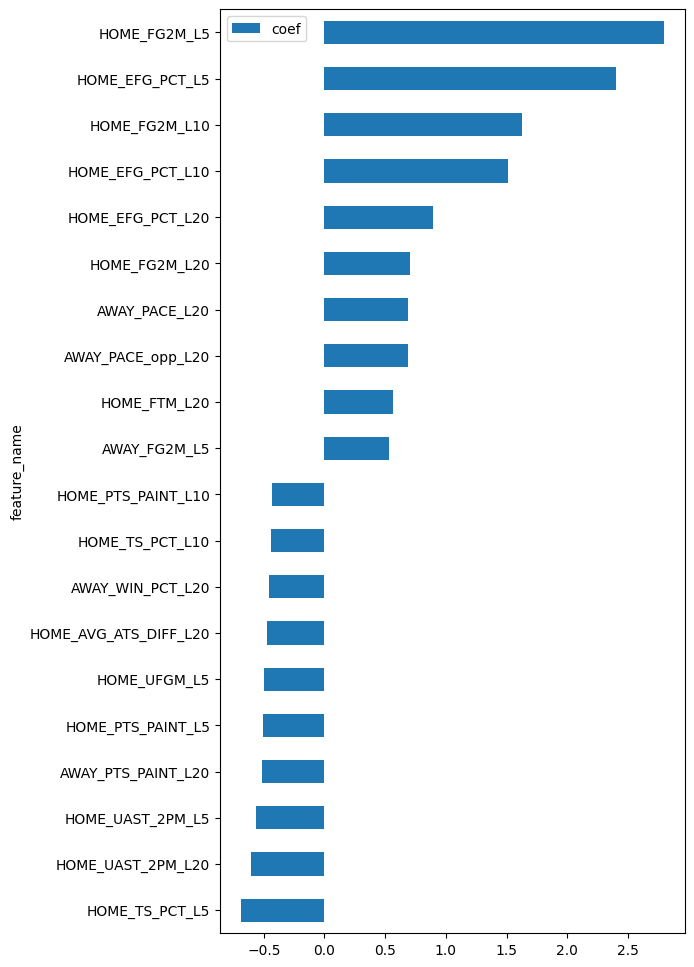

In [ ]:
sgd_coef_df = view_model_coefs(best_sgd_reg.named_steps['sgd'].estimators_[0], X_train)

In [ ]:
sgd_coef_df.sort_values(['coef'], ascending=False)

,feature_name,coef
0,HOME_FG2M_L5,2.794521
87,HOME_EFG_PCT_L5,2.399840
94,HOME_FG2M_L10,1.628221
181,HOME_EFG_PCT_L10,1.514932
275,HOME_EFG_PCT_L20,0.896403
...,...,...
33,HOME_PTS_PAINT_L5,-0.504502
506,AWAY_PTS_PAINT_L20,-0.515164
36,HOME_UAST_2PM_L5,-0.566549
224,HOME_UAST_2PM_L20,-0.602828


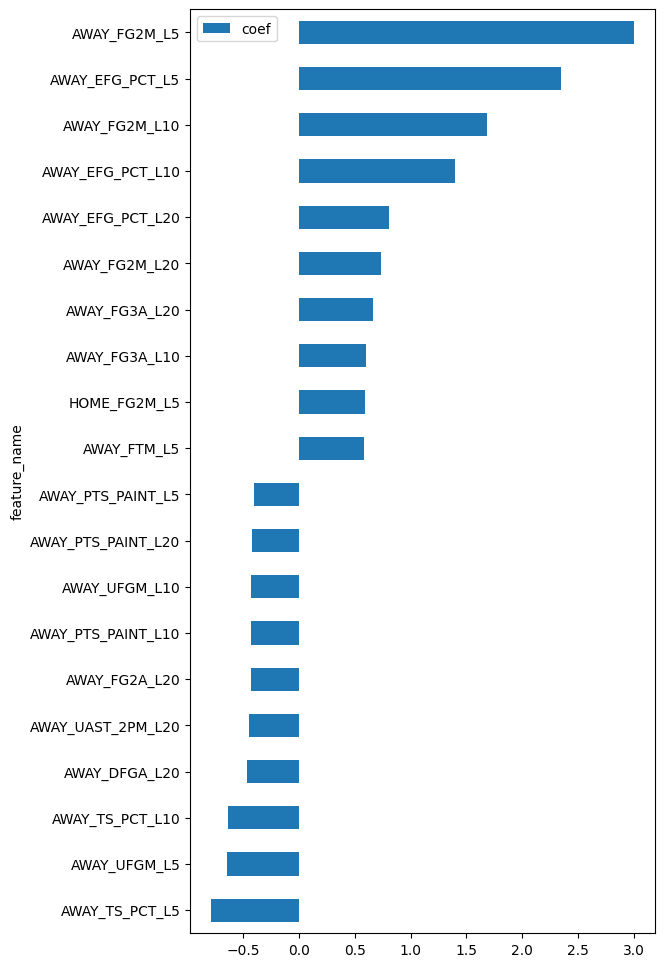

In [ ]:
sgd_coef_df = view_model_coefs(best_sgd_reg.named_steps['sgd'].estimators_[1], X_train)

LGBoost or XGBoost


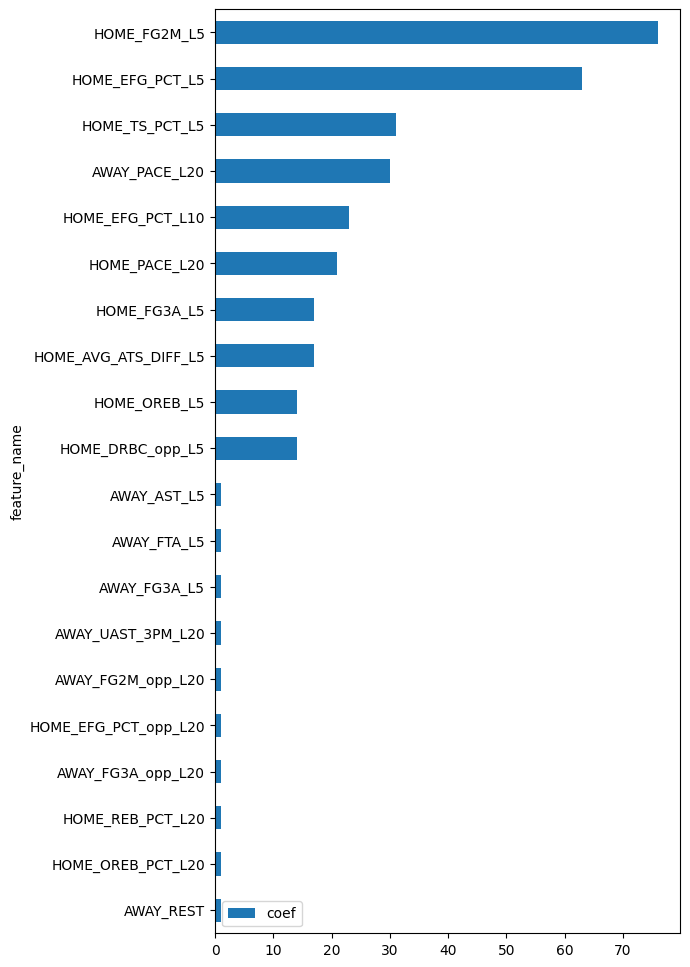

In [ ]:
lgb_coef_df = view_model_coefs(best_lgb_reg.estimators_[0], X_train)

LGBoost or XGBoost


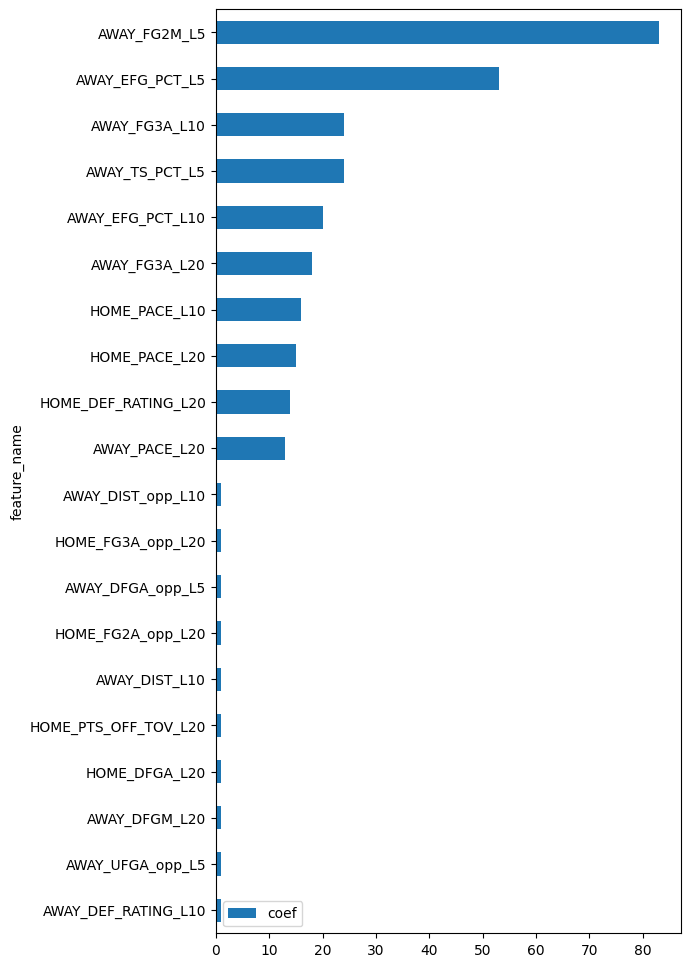

In [ ]:
lgb_coef_df = view_model_coefs(best_lgb_reg.estimators_[1], X_train)